# LSTM FORECAST

# https://www.relataly.com/stock-price-prediction-multi-output-regression-using-neural-networks-in-python/5800/



In [49]:

# import pandas_datareader as webreader # Remote data access for pandas
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from keras.models import Sequential # Deep learning library, used for neural networks
from keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns
import datetime as dt

# GET DATA


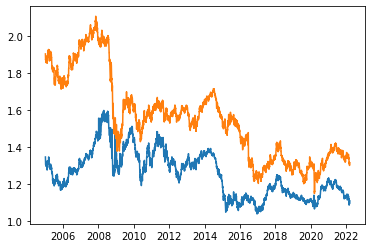

In [50]:

# get data
df = pd.read_csv(r'C:\Users\Chris\Desktop\UlsterUniversity\Final Project\PySimpleGUI\Closedf.csv', parse_dates = True, index_col = 'Date')
df = df[['EURUSD=X', 'GBPUSD=X']]

# specifying period
end = dt.datetime.now()  # end date is now
start = dt.datetime(2005, 1, 1)   # start date  
df = df[start:end]
# setting frequency
df = df.asfreq('D') # changes frequency to daily
#df.index # checks the frequency at bottom of printout
    
# fills NaN's
df = df.fillna(method = 'backfill')  # takes the close rows and fills in missing values back
df = df.fillna(method = 'ffill')  # takes the close rows and fills in missing values forwards, for some markets operating at different days
    
#returns dataframe

## explore the columns

# Plot line charts
plt.plot(df)
plt.show()


# PREPROCESS THE DATA

In [51]:
# Indexing Batches
df_train = df.sort_values(by=['Date']).copy()

# Save a copy of the dates index, before we need to reset it to numbers
date_index = df_train.index

# We reset the index, so we can convert the date-index to a number-index
df_train = df_train.reset_index(drop=True).copy()


In [52]:
# preparing the data w/ feature engineering

def prepare_data(df):

    # List of considered Features - change to list of headings in df (df.index())
    # using all columns in df

    # Create the dataset with features and filter the data to the list of FEATURES
    df_filter = df # using all columns in df
    
    # Convert the data to numpy values
    np_filter_unscaled = np.array(df_filter)
    #np_filter_unscaled = np.reshape(np_unscaled, (df_filter.shape[0], -1))
    print(np_filter_unscaled.shape)

    np_c_unscaled = np.array(df).reshape(-1, 1)
    
    return np_filter_unscaled, np_c_unscaled
    
np_filter_unscaled, np_c_unscaled = prepare_data(df_train)
                                          
# Creating a separate scaler that works on a single column for scaling predictions
# Scale each feature to a range between 0 and 1
scaler_train = MinMaxScaler()
np_scaled = scaler_train.fit_transform(np_filter_unscaled)
    
# Create a separate scaler for a single column
scaler_pred = MinMaxScaler()
np_scaled_c = scaler_pred.fit_transform(np_c_unscaled)  

(6286, 2)


In [53]:

# Set the input_sequence_length length - this is the timeframe used to make a single prediction
input_sequence_length = 50
# The output sequence length is the number of steps that the neural network predicts
output_sequence_length = 10 #

# Prediction Index -  *** will need to change this to a variable to loop around df
index_Close = df_train.columns.get_loc('EURUSD=X')

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_length = math.ceil(np_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_scaled[0:train_data_length, :]
test_data = np_scaled[train_data_length - input_sequence_length:, :]


In [54]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, input_sequence_length time steps per sample, and f features
def partition_dataset(input_sequence_length, output_sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(input_sequence_length, data_len - output_sequence_length):
        x.append(data[i-input_sequence_length:i,:]) #contains input_sequence_length values 0-input_sequence_length * columns
        y.append(data[i:i + output_sequence_length, index_Close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(input_sequence_length, output_sequence_length, train_data)
x_test, y_test = partition_dataset(input_sequence_length, output_sequence_length, test_data)


# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4949, 50, 2) (4949, 30)
(1227, 50, 2) (1227, 30)


<function matplotlib.pyplot.show(close=None, block=None)>

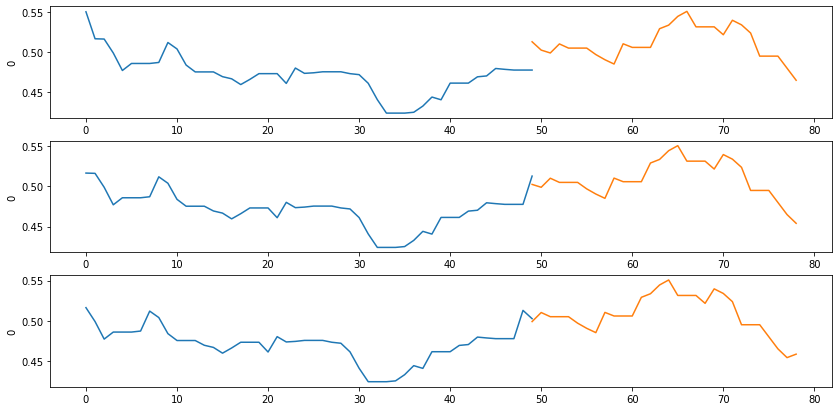

In [55]:

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
# print(x_train[1][input_sequence_length-1][index_Close])
# print(y_train[0])

nrows = 3 # number of shifted plots
fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(14, 7))
for i in range(nrows):
    sns.lineplot(y = pd.DataFrame(x_train[i])[index_Close], x = range(input_sequence_length), ax = ax[i])
    sns.lineplot(y = y_train[i], x = range(input_sequence_length -1, input_sequence_length + output_sequence_length - 1), ax = ax[i])
plt.show


In [56]:

# prepare the neural network archiecture and train th emulti-output regression model

# Configure the neural network model
model = Sequential()
n_output_neurons = output_sequence_length

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_input_neurons = x_train.shape[1] * x_train.shape[2]
print(n_input_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_input_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_input_neurons, return_sequences=False))
model.add(Dense(20))
model.add(Dense(n_output_neurons))

# Compile the model
model.compile(optimizer='adam', loss='mse')

100 50 2


Epoch 1/10
310/310 [==============================] - 20s 52ms/step - loss: 0.0131 - val_loss: 0.0012
Epoch 2/10
310/310 [==============================] - 14s 47ms/step - loss: 0.0031 - val_loss: 8.2767e-04
Epoch 3/10
310/310 [==============================] - 15s 48ms/step - loss: 0.0029 - val_loss: 8.2269e-04
Epoch 4/10
310/310 [==============================] - 15s 49ms/step - loss: 0.0029 - val_loss: 6.7699e-04
Epoch 5/10
310/310 [==============================] - 15s 48ms/step - loss: 0.0028 - val_loss: 6.9526e-04
Epoch 6/10
310/310 [==============================] - 14s 46ms/step - loss: 0.0027 - val_loss: 6.5297e-04
Epoch 7/10
310/310 [==============================] - 15s 48ms/step - loss: 0.0027 - val_loss: 6.9644e-04
Epoch 8/10
310/310 [==============================] - 15s 48ms/step - loss: 0.0026 - val_loss: 7.8424e-04
Epoch 9/10
310/310 [==============================] - 15s 48ms/step - loss: 0.0026 - val_loss: 6.3984e-04
Epoch 10/10
310/310 [=============================

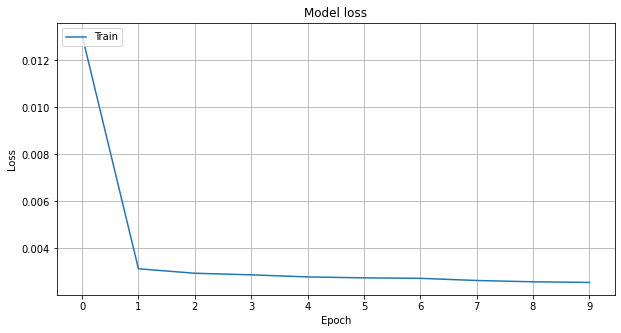

In [57]:
# Training the model
epochs = 10
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])



# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [58]:

# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test).reshape(-1, output_sequence_length)
y_test_unscaled.shape

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')


Median Absolute Error (MAE): 0.02
Mean Absolute Percentage Error (MAPE): 1.59 %
Median Absolute Percentage Error (MDAPE): 1.18 %


In [59]:

def plot_multi_test_forecast(i, s, x_test, y_test_unscaled, y_pred_unscaled): 
    
    # reshape the testset into a one-dimensional array, so that it fits to the pred scaler
    x_test_scaled_reshaped = np.array(pd.DataFrame(x_test[i])[index_Close]).reshape(-1, 1)
    
    # undo the scaling on the testset
    df_test = pd.DataFrame(scaler_pred.inverse_transform(x_test_scaled_reshaped) )

    # set the max index 
    test_max_index = df_test.shape[0]
    pred_max_index = y_pred_unscaled[0].shape[0]
    test_index = range(i, i + test_max_index)
    pred_index = range(i + test_max_index, i + test_max_index + pred_max_index)
    
    # package y_pred_unscaled and y_test_unscaled into a dataframe with columns pred and true
    data = pd.DataFrame(list(zip(y_pred_unscaled[s], y_test_unscaled[i])), columns=['pred', 'true']) #
    
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.title(f"Predictions vs Ground Truth {pred_index}", fontsize=12)
    ax.set(ylabel = 'stockname' + "_stock_price_quotes")
    
    sns.lineplot(data = df_test,  y = df_test[0], x=test_index, color="#039dfc", linewidth=1.0, label='test')
    sns.lineplot(data = data,  y='true', x=pred_index, color="g", linewidth=1.0, label='true')
    sns.lineplot(data = data,  y='pred', x=pred_index, color="r", linewidth=1.0, label='pred')

x_test_unscaled = scaler_pred.inverse_transform(np.array(pd.DataFrame(x_test[0])[index_Close]).reshape(-1, 1)) 
df_test = pd.DataFrame(x_test_unscaled)

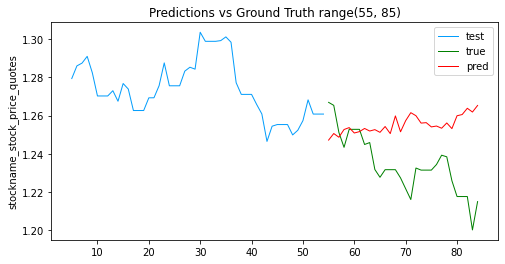

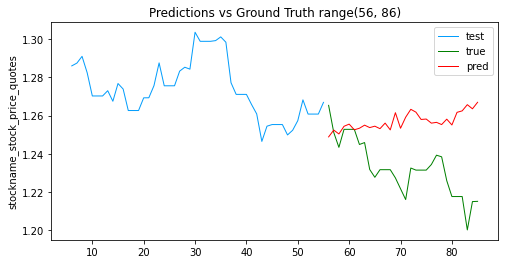

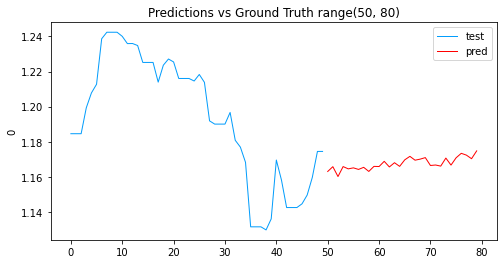

In [60]:
for i in range(5, 7): #i is the starting point for the batch in the time-series
    #data = pd.DataFrame(list(zip(y_pred[i], y_test_unscaled[i])), columns=['pred', 'true'], index=range(55,65))
    plot_multi_test_forecast(i, i, x_test, y_test_unscaled, y_pred)


    # create a new forecast

    def plot_new_multi_forecast(i_test, i_pred, x_test, y_pred_unscaled): 
    
    # reshape the testset into a one-dimensional array, so that it fits to the pred scaler
        x_test_scaled_reshaped = np.array(pd.DataFrame(x_test[i_test])[index_Close]).reshape(-1, 1)
    
    # undo the scaling on the testset
        df_test = pd.DataFrame(scaler_pred.inverse_transform(x_test_scaled_reshaped) )

    # set the max index 
        test_max_index = df_test.shape[0]
        pred_max_index = y_pred_unscaled[0].shape[0]
        test_index = range(i_test, i_test + test_max_index)
        pred_index = range(i_test + test_max_index, i_test + test_max_index + pred_max_index)
    
        data = pd.DataFrame(list(zip(y_pred_unscaled[i_pred])), columns=['pred']) #
    
        fig, ax = plt.subplots(figsize=(8, 4))
        plt.title(f"Predictions vs Ground Truth {pred_index}", fontsize=12)
        sns.lineplot(data = df_test,  y = df_test[0], x=test_index, color="#039dfc", linewidth=1.0, label='test')
        sns.lineplot(data = data,  y='pred', x=pred_index, color="r", linewidth=1.0, label='pred')
    
# get the highest index from the x_test dataset
index_max = x_test.shape[0]
x_test_new = np_scaled[-51:-1,:].reshape(1,50,2) # changed from 5 to 2 for number of columns used

# undo the scaling of the predictions
y_pred_scaled = model.predict(x_test_new)
y_pred = scaler_pred.inverse_transform(y_pred_scaled)

# plot the predictions
plot_new_multi_forecast(0, 0, x_test_new, y_pred)